In [1]:
import sys
import os
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

sys.path.append(os.path.expanduser('~/Documents/SubSeas'))
from comparison import create_composite

In [2]:
def get_data(npreds: int, std: bool = False):
    """
    Loading data from disk
    """
    name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
    savename = f'/nobackup/users/straaten/interpretation/{name}_{npreds}preds_{"std_" if std else ""}'
    shap_sub = pd.read_hdf(f'{savename}shap_sub.h5', key = 'explanation')
    inpgrad_sub = pd.read_hdf(f'{savename}inpgrad_sub.h5', key = 'explanation')
    outpos = pd.read_hdf(f'{savename}outpos.h5', key = 'values')
    return shap_sub, inpgrad_sub, outpos
    
def get_slices(npreds: int):
    """
    Defining interesting slices, based on the data's order in which it is saved.
    """
    if npreds == 4:
        slices = {'west_pacific':slice(1960,nsamples),
                  'soilm_counter':slice(1685,1840),
                  'soilm_driven':slice(0,65)}
    elif npreds == 3:
        slices = {'w_pacif_amplif':slice(25,155),
              'w_pacif_damp':slice(370,480),
              'neutral_neg_w_pacif':slice(1250,1710)}
    else: # == 2
        slices = {'w_pacif_amplif':slice(0,145),
              'w_pacif_damp':slice(2090,2255),
                'neutral_neg_w_pacif':slice(480,1050)}
    return slices

def get_timestamps(sl: slice, data: pd.DataFrame):
    timestamps = data.index[sl].get_level_values('time').unique()
    return timestamps

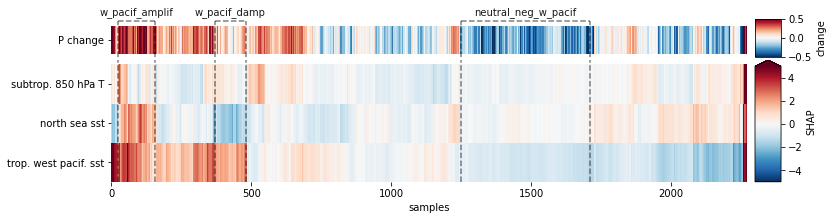

In [148]:
npreds = 3
slices = get_slices(npreds)
shap_sub, inpgrad_sub, outpos = get_data(npreds = npreds, std = False)
nsamples = len(shap_sub.index)
order = shap_sub.index
response = 'change'

fig = plt.figure(figsize=(12,3), facecolor = 'white')
gs1 = GridSpec(nrows = npreds+1, ncols = 20, hspace=0.1, wspace = 0.3)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
ax_expl.set_xlabel('samples')

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

fig.colorbar(expl, cax = ax_cbar_expl, label = 'SHAP', extend = 'max')
fig.colorbar(cor, cax = ax_cbar_cor, label = response)

for i in ax_expl.spines:
    ax_expl.spines[i].set_visible(False)
    ax_cor.spines[i].set_visible(False)

expl_height = npreds + 0.1
cor_height = 1.2
color = 'black'
alpha = 0.5
ls = '--'
for key, sl in slices.items():
    ax_expl.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_expl.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_cor.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_cor.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_cor.hlines(y = cor_height, xmin = sl.start, xmax = sl.stop, color = color, alpha = alpha, linestyles = ls)
    ax_cor.text(x = np.mean([sl.start,sl.stop]), y = cor_height + 0.1, s = key, color = color, alpha = 0.9, verticalalignment = 'bottom', horizontalalignment = 'center')

ax_expl.set_ylim(bottom = 0, top = expl_height)
ax_cor.set_ylim(bottom = -0.1)
plt.savefig(os.path.expanduser('~/Pictures/shap_annotated.pdf'))
plt.show()

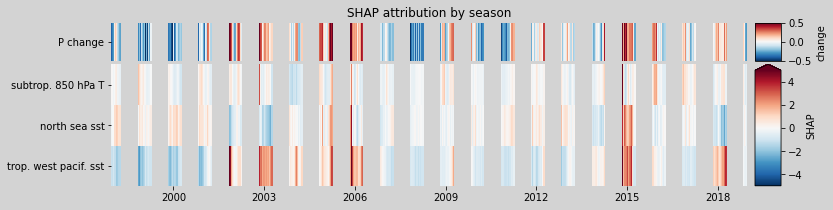

In [146]:
seps = pd.date_range(start = order.get_level_values('time').min(), end = order.get_level_values('time').max(), freq = 'A-SEP')
n_between = 150
gap_index = pd.MultiIndex.from_product([seps, np.arange(16,16+n_between)], names = order.names)
neworder = order.append(gap_index).sort_values()
response = 'change'
#response = 'perc_change'

facecolor = 'lightgrey'

fig = plt.figure(figsize=(12,3), facecolor = facecolor)
gs1 = GridSpec(nrows = npreds+1, ncols = 20, hspace=0.1, wspace = 0.3)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

cor = ax_cor.pcolor(outpos[[response]].reindex(neworder).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('SHAP attribution by season')
ax_cor.set_facecolor(facecolor)
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

expl = ax_expl.pcolor(shap_sub.reindex(neworder).T.values, vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax_expl.set_facecolor(facecolor)
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)

# Color bars
fig.colorbar(cor, cax = ax_cbar_cor, label = response)
fig.colorbar(expl, cax = ax_cbar_expl,label = 'SHAP', extend = 'max')
ax_cbar_expl.set_facecolor(facecolor)
ax_cbar_cor.set_facecolor(facecolor)

for i in ax_cor.spines:
    ax_cor.spines[i].set_visible(False)
    ax_expl.spines[i].set_visible(False)

# Time axis
stamps = pd.date_range('2000-06-01','2019-06-01', freq = 'A-JUN')[::3]
inds = np.where(neworder.get_level_values('time').map(lambda t: t in stamps).values)[0]
ax_expl.set_xticks(inds)
ax_expl.set_xticklabels(stamps.year)
plt.show()

## Situation as observed at forecast, observed at initialization, and as forecast at forecast

In [4]:
z_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/z300_nhnorm.anom.nc')
z_31 = xr.open_dataset('/nobackup_1/users/straaten/processed/z300_nhnorm.31.anom.nc')[z_daily.name]

sst_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/sst_nhplus.anom.nc')
sst_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/sst_nhplus.21.anom.nc')[sst_daily.name]

swvl13_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/swvl13_europe.anom.nc')
swvl13_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/swvl13_europe.21.anom.nc')[swvl13_daily.name]

t850_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/t850_nhblock.anom.nc')
t850_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/t850_nhblock.21.anom.nc')[t850_daily.name]

variables = {'z':z_31,'sst':sst_21,'swvl13':swvl13_21,'t850':t850_21}
colorscales = pd.Series(['RdBu_r','RdBu_r','RdBu','RdBu_r'], index = variables.keys())
timeaggs = pd.Series([31,21,21,31], index = variables.keys())

In [5]:
def data_for_pcolormesh(array, shading:str):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    if shading == 'flat':
        lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
        lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge (only for flat shating)
    return lons, lats, array.values.squeeze()

In [20]:
## Precomputing composites,
final = []
for npreds in [2,3,4]:
    shap_sub, _, _ = get_data(npreds = npreds, std = False)
    separation_max = shap_sub.index.get_level_values('separation').max()
    separation_min = shap_sub.index.get_level_values('separation').min()
    leadtimerange = range(separation_min+1, separation_max+2) # Defined including first day (max = 46)
    slices = get_slices(npreds = npreds)
    for key,sl in slices.items():
        composites = pd.DataFrame(np.nan, index = variables.keys(), 
                                  columns = pd.MultiIndex.from_product([[npreds],[key],['init','obs','forc']],names=['npreds','slice','moment']), 
                                  dtype = object)
        timestamps = get_timestamps(sl = sl, data = shap_sub)
        init_timestamps = shap_sub.index.get_level_values('time') - pd.TimedeltaIndex(shap_sub.index.get_level_values('separation') + 1, unit = 'day')
        init_timestamps = init_timestamps[sl] 
        for variable, array in variables.items():
            composites.loc[variable,(npreds,key,'init')] = array.loc[init_timestamps,:,:].mean('time')
            composites.loc[variable,(npreds,key,'obs')] = array.loc[timestamps,:,:].mean('time')
            # Now the model forecast
            if not (variable == 't850'):
                _, model_comp = create_composite(dates = timestamps, variable = variable, leadtimerange = leadtimerange, time_agg = timeaggs.loc[variable])
                composites.loc[variable,(npreds,key,'forc')] = model_comp
        final.append(composites)
final = pd.concat(final, axis = 1)

climatology directly loaded
Starting: 96422
2 of range(13, 17) present in 2006-06-11 00:00:00
2006-06-11 00:00:00 added
1 of range(13, 17) present in 2006-06-12 00:00:00
2006-06-12 00:00:00 added
1 of range(13, 17) present in 2006-06-13 00:00:00
2006-06-13 00:00:00 added
1 of range(13, 17) present in 2006-06-14 00:00:00
2006-06-14 00:00:00 added
1 of range(13, 17) present in 2006-06-15 00:00:00
2006-06-15 00:00:00 added
1 of range(13, 17) present in 2006-06-16 00:00:00
2006-06-16 00:00:00 added
1 of range(13, 17) present in 2006-06-17 00:00:00
2006-06-17 00:00:00 added
2 of range(13, 17) present in 2006-06-18 00:00:00
2006-06-18 00:00:00 added
2 of range(13, 17) present in 2015-06-18 00:00:00
2015-06-18 00:00:00 added
2 of range(13, 17) present in 2015-06-19 00:00:00
2015-06-19 00:00:00 added
2 of range(13, 17) present in 2015-06-20 00:00:00
2015-06-20 00:00:00 added
2 of range(13, 17) present in 2015-06-21 00:00:00
2015-06-21 00:00:00 added
2 of range(13, 17) present in 2015-06-25 00:

1 of range(13, 17) present in 2015-07-15 00:00:00
2015-07-15 00:00:00 added
1 of range(13, 17) present in 2015-07-14 00:00:00
2015-07-14 00:00:00 added
1 of range(13, 17) present in 2005-08-17 00:00:00
2005-08-17 00:00:00 added
1 of range(13, 17) present in 2005-08-16 00:00:00
2005-08-16 00:00:00 added
1 of range(13, 17) present in 2006-06-07 00:00:00
2006-06-07 00:00:00 added
1 of range(13, 17) present in 2006-06-06 00:00:00
2006-06-06 00:00:00 added
1 of range(13, 17) present in 2006-06-05 00:00:00
2006-06-05 00:00:00 added
2 of range(13, 17) present in 2006-06-04 00:00:00
2006-06-04 00:00:00 added
1 of range(13, 17) present in 2005-08-15 00:00:00
2005-08-15 00:00:00 added
2 of range(13, 17) present in 2005-08-14 00:00:00
2005-08-14 00:00:00 added
1 of range(13, 17) present in 2005-08-13 00:00:00
2005-08-13 00:00:00 added
1 of range(13, 17) present in 2005-08-12 00:00:00
2005-08-12 00:00:00 added
1 of range(13, 17) present in 2005-08-11 00:00:00
2005-08-11 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2005-08-08 00:00:00
2005-08-08 00:00:00 added
1 of range(13, 17) present in 2005-08-09 00:00:00
2005-08-09 00:00:00 added
1 of range(13, 17) present in 2005-08-10 00:00:00
2005-08-10 00:00:00 added
1 of range(13, 17) present in 2015-06-08 00:00:00
2015-06-08 00:00:00 added
1 of range(13, 17) present in 2015-06-09 00:00:00
2015-06-09 00:00:00 added
1 of range(13, 17) present in 2015-06-10 00:00:00
2015-06-10 00:00:00 added
2 of range(13, 17) present in 2015-06-11 00:00:00
2015-06-11 00:00:00 added
1 of range(13, 17) present in 2015-06-12 00:00:00
2015-06-12 00:00:00 added
1 of range(13, 17) present in 2015-06-14 00:00:00
2015-06-14 00:00:00 added
1 of range(13, 17) present in 2015-06-13 00:00:00
2015-06-13 00:00:00 added
2 of range(13, 17) present in 2005-06-19 00:00:00
2005-06-19 00:00:00 added
2 of range(13, 17) present in 2005-06-20 00:00:00
2005-06-20 00:00:00 added
2 of range(13, 17) present in 2005-06-21 00:00:00
2005-06-21 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2005-08-18 00:00:00
2005-08-18 00:00:00 added
1 of range(13, 17) present in 2005-08-19 00:00:00
2005-08-19 00:00:00 added
1 of range(13, 17) present in 2005-08-20 00:00:00
2005-08-20 00:00:00 added
1 of range(13, 17) present in 2015-06-07 00:00:00
2015-06-07 00:00:00 added
1 of range(13, 17) present in 2015-06-06 00:00:00
2015-06-06 00:00:00 added
1 of range(13, 17) present in 2015-06-05 00:00:00
2015-06-05 00:00:00 added
2 of range(13, 17) present in 2006-07-03 00:00:00
2006-07-03 00:00:00 added
1 of range(13, 17) present in 2006-07-04 00:00:00
2006-07-04 00:00:00 added
1 of range(13, 17) present in 2006-07-05 00:00:00
2006-07-05 00:00:00 added
1 of range(13, 17) present in 2006-07-06 00:00:00
2006-07-06 00:00:00 added
2 of range(13, 17) present in 2010-06-04 00:00:00
2010-06-04 00:00:00 added
1 of range(13, 17) present in 2010-06-03 00:00:00
2010-06-03 00:00:00 added
1 of range(13, 17) present in 2010-06-02 00:00:00
2010-06-02 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2018-06-07 00:00:00
2018-06-07 00:00:00 added
1 of range(13, 17) present in 2003-07-09 00:00:00
2003-07-09 00:00:00 added
2 of range(13, 17) present in 2002-06-18 00:00:00
2002-06-18 00:00:00 added
1 of range(13, 17) present in 2003-07-08 00:00:00
2003-07-08 00:00:00 added
1 of range(13, 17) present in 2003-07-07 00:00:00
2003-07-07 00:00:00 added
1 of range(13, 17) present in 2018-08-16 00:00:00
2018-08-16 00:00:00 added
2 of range(13, 17) present in 2003-07-24 00:00:00
2003-07-24 00:00:00 added
1 of range(13, 17) present in 2003-07-23 00:00:00
2003-07-23 00:00:00 added
1 of range(13, 17) present in 2003-07-14 00:00:00
2003-07-14 00:00:00 added
1 of range(13, 17) present in 2003-07-15 00:00:00
2003-07-15 00:00:00 added
2 of range(13, 17) present in 2003-07-17 00:00:00
2003-07-17 00:00:00 added
1 of range(13, 17) present in 2003-07-16 00:00:00
2003-07-16 00:00:00 added
1 of range(13, 17) present in 2003-07-22 00:00:00
2003-07-22 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2006-06-23 00:00:00
2006-06-23 00:00:00 added
2 of range(13, 17) present in 2003-07-10 00:00:00
2003-07-10 00:00:00 added
1 of range(13, 17) present in 2003-07-11 00:00:00
2003-07-11 00:00:00 added
1 of range(13, 17) present in 2003-07-12 00:00:00
2003-07-12 00:00:00 added
1 of range(13, 17) present in 2003-07-13 00:00:00
2003-07-13 00:00:00 added
2 of range(13, 17) present in 2006-07-17 00:00:00
2006-07-17 00:00:00 added
1 of range(13, 17) present in 2006-07-18 00:00:00
2006-07-18 00:00:00 added
1 of range(13, 17) present in 2006-07-19 00:00:00
2006-07-19 00:00:00 added
1 of range(13, 17) present in 2006-07-20 00:00:00
2006-07-20 00:00:00 added
1 of range(13, 17) present in 2018-07-01 00:00:00
2018-07-01 00:00:00 added
1 of range(13, 17) present in 2006-07-16 00:00:00
2006-07-16 00:00:00 added
1 of range(13, 17) present in 2006-07-15 00:00:00
2006-07-15 00:00:00 added
1 of range(13, 17) present in 2006-07-14 00:00:00
2006-07-14 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2018-08-20 00:00:00
2018-08-20 00:00:00 added
1 of range(13, 17) present in 2018-08-18 00:00:00
2018-08-18 00:00:00 added
2 of range(13, 17) present in 2003-06-18 00:00:00
2003-06-18 00:00:00 added
2 of range(13, 17) present in 2003-06-19 00:00:00
2003-06-19 00:00:00 added
2 of range(13, 17) present in 2003-06-20 00:00:00
2003-06-20 00:00:00 added
2 of range(13, 17) present in 2003-06-21 00:00:00
2003-06-21 00:00:00 added
1 of range(13, 17) present in 2018-08-19 00:00:00
2018-08-19 00:00:00 added
2 of range(13, 17) present in 2018-08-21 00:00:00
2018-08-21 00:00:00 added
1 of range(13, 17) present in 2003-08-18 00:00:00
2003-08-18 00:00:00 added
1 of range(13, 17) present in 2003-08-19 00:00:00
2003-08-19 00:00:00 added
1 of range(13, 17) present in 2003-08-20 00:00:00
2003-08-20 00:00:00 added
2 of range(13, 17) present in 2003-08-21 00:00:00
2003-08-21 00:00:00 added
1 of range(13, 17) present in 2003-08-22 00:00:00
2003-08-22 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2003-08-07 00:00:00
2003-08-07 00:00:00 added
1 of range(13, 17) present in 2003-07-27 00:00:00
2003-07-27 00:00:00 added
1 of range(13, 17) present in 2003-07-26 00:00:00
2003-07-26 00:00:00 added
1 of range(13, 17) present in 2003-07-25 00:00:00
2003-07-25 00:00:00 added
1 of range(13, 17) present in 2003-07-29 00:00:00
2003-07-29 00:00:00 added
1 of range(13, 17) present in 2003-07-30 00:00:00
2003-07-30 00:00:00 added
2 of range(13, 17) present in 2003-07-31 00:00:00
2003-07-31 00:00:00 added
1 of range(13, 17) present in 2003-07-28 00:00:00
2003-07-28 00:00:00 added
1 of range(13, 17) present in 2018-08-10 00:00:00
2018-08-10 00:00:00 added
1 of range(13, 17) present in 2018-08-08 00:00:00
2018-08-08 00:00:00 added
1 of range(13, 17) present in 2003-08-03 00:00:00
2003-08-03 00:00:00 added
1 of range(13, 17) present in 2003-08-02 00:00:00
2003-08-02 00:00:00 added
1 of range(13, 17) present in 2003-08-01 00:00:00
2003-08-01 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2011-06-20 00:00:00
2011-06-20 00:00:00 added
2 of range(13, 17) present in 2011-06-21 00:00:00
2011-06-21 00:00:00 added
2 of range(13, 17) present in 2011-06-22 00:00:00
2011-06-22 00:00:00 added
1 of range(13, 17) present in 2007-08-17 00:00:00
2007-08-17 00:00:00 added
1 of range(13, 17) present in 2007-08-16 00:00:00
2007-08-16 00:00:00 added
1 of range(13, 17) present in 2007-08-15 00:00:00
2007-08-15 00:00:00 added
1 of range(13, 17) present in 2012-07-13 00:00:00
2012-07-13 00:00:00 added
1 of range(13, 17) present in 2012-07-12 00:00:00
2012-07-12 00:00:00 added
1 of range(13, 17) present in 2012-07-11 00:00:00
2012-07-11 00:00:00 added
2 of range(13, 17) present in 2011-06-11 00:00:00
2011-06-11 00:00:00 added
1 of range(13, 17) present in 2011-06-12 00:00:00
2011-06-12 00:00:00 added
1 of range(13, 17) present in 2011-06-13 00:00:00
2011-06-13 00:00:00 added
1 of range(13, 17) present in 2011-06-14 00:00:00
2011-06-14 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2011-07-05 00:00:00
2011-07-05 00:00:00 added
2 of range(13, 17) present in 2011-07-03 00:00:00
2011-07-03 00:00:00 added
1 of range(13, 17) present in 2011-07-06 00:00:00
2011-07-06 00:00:00 added
1 of range(13, 17) present in 2000-06-30 00:00:00
2000-06-30 00:00:00 added
1 of range(13, 17) present in 2000-07-01 00:00:00
2000-07-01 00:00:00 added
1 of range(13, 17) present in 2000-07-02 00:00:00
2000-07-02 00:00:00 added
2 of range(13, 17) present in 2000-07-03 00:00:00
2000-07-03 00:00:00 added
2 of range(13, 17) present in 2000-06-26 00:00:00
2000-06-26 00:00:00 added
2 of range(13, 17) present in 2000-06-25 00:00:00
2000-06-25 00:00:00 added
2 of range(13, 17) present in 2000-06-23 00:00:00
2000-06-23 00:00:00 added
2 of range(13, 17) present in 2000-06-24 00:00:00
2000-06-24 00:00:00 added
2 of range(13, 17) present in 2000-06-04 00:00:00
2000-06-04 00:00:00 added
1 of range(13, 17) present in 2000-06-03 00:00:00
2000-06-03 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2008-07-17 00:00:00
2008-07-17 00:00:00 added
1 of range(13, 17) present in 2008-07-14 00:00:00
2008-07-14 00:00:00 added
1 of range(13, 17) present in 2008-07-16 00:00:00
2008-07-16 00:00:00 added
1 of range(13, 17) present in 2008-07-15 00:00:00
2008-07-15 00:00:00 added
2 of range(13, 17) present in 2008-06-21 00:00:00
2008-06-21 00:00:00 added
2 of range(13, 17) present in 2008-06-20 00:00:00
2008-06-20 00:00:00 added
1 of range(13, 17) present in 2008-07-11 00:00:00
2008-07-11 00:00:00 added
1 of range(13, 17) present in 2008-06-13 00:00:00
2008-06-13 00:00:00 added
1 of range(13, 17) present in 2008-06-14 00:00:00
2008-06-14 00:00:00 added
1 of range(13, 17) present in 1999-06-07 00:00:00
1999-06-07 00:00:00 added
1 of range(13, 17) present in 1999-06-06 00:00:00
1999-06-06 00:00:00 added
1 of range(13, 17) present in 1999-06-05 00:00:00
1999-06-05 00:00:00 added
2 of range(13, 17) present in 2008-06-22 00:00:00
2008-06-22 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2010-08-17 00:00:00
2010-08-17 00:00:00 added
2 of range(13, 17) present in 1998-07-10 00:00:00
1998-07-10 00:00:00 added
1 of range(13, 17) present in 1998-07-09 00:00:00
1998-07-09 00:00:00 added
1 of range(13, 17) present in 1998-07-08 00:00:00
1998-07-08 00:00:00 added
1 of range(13, 17) present in 1998-07-07 00:00:00
1998-07-07 00:00:00 added
1 of range(13, 17) present in 2008-06-01 00:00:00
2008-06-01 00:00:00 added
1 of range(13, 17) present in 2008-06-02 00:00:00
2008-06-02 00:00:00 added
1 of range(13, 17) present in 2008-06-03 00:00:00
2008-06-03 00:00:00 added
2 of range(13, 17) present in 2008-06-04 00:00:00
2008-06-04 00:00:00 added
1 of range(13, 17) present in 2008-06-15 00:00:00
2008-06-15 00:00:00 added
1 of range(13, 17) present in 2008-06-16 00:00:00
2008-06-16 00:00:00 added
1 of range(13, 17) present in 2008-06-17 00:00:00
2008-06-17 00:00:00 added
1 of range(13, 17) present in 2008-06-08 00:00:00
2008-06-08 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2007-07-15 00:00:00
2007-07-15 00:00:00 added
1 of range(13, 17) present in 2007-07-16 00:00:00
2007-07-16 00:00:00 added
2 of range(13, 17) present in 2009-06-04 00:00:00
2009-06-04 00:00:00 added
1 of range(13, 17) present in 2009-06-03 00:00:00
2009-06-03 00:00:00 added
1 of range(13, 17) present in 2009-06-02 00:00:00
2009-06-02 00:00:00 added
1 of range(13, 17) present in 2009-06-01 00:00:00
2009-06-01 00:00:00 added
2 of range(13, 17) present in 2010-07-10 00:00:00
2010-07-10 00:00:00 added
1 of range(13, 17) present in 2010-07-09 00:00:00
2010-07-09 00:00:00 added
1 of range(13, 17) present in 2010-07-08 00:00:00
2010-07-08 00:00:00 added
1 of range(13, 17) present in 2010-07-07 00:00:00
2010-07-07 00:00:00 added
2 of range(13, 17) present in 2007-07-10 00:00:00
2007-07-10 00:00:00 added
1 of range(13, 17) present in 2007-07-11 00:00:00
2007-07-11 00:00:00 added
1 of range(13, 17) present in 2007-07-12 00:00:00
2007-07-12 00:00:00 added
1 of range(1

1 of range(13, 17) present in 1999-06-10 00:00:00
1999-06-10 00:00:00 added
2 of range(13, 17) present in 1999-06-11 00:00:00
1999-06-11 00:00:00 added
2 of range(13, 17) present in 1999-07-03 00:00:00
1999-07-03 00:00:00 added
1 of range(13, 17) present in 1999-07-04 00:00:00
1999-07-04 00:00:00 added
1 of range(13, 17) present in 1999-07-05 00:00:00
1999-07-05 00:00:00 added
1 of range(13, 17) present in 1999-07-06 00:00:00
1999-07-06 00:00:00 added
1 of range(13, 17) present in 2008-07-06 00:00:00
2008-07-06 00:00:00 added
1 of range(13, 17) present in 2001-06-01 00:00:00
2001-06-01 00:00:00 added
1 of range(13, 17) present in 2001-06-02 00:00:00
2001-06-02 00:00:00 added
1 of range(13, 17) present in 2001-06-03 00:00:00
2001-06-03 00:00:00 added
2 of range(13, 17) present in 2001-06-04 00:00:00
2001-06-04 00:00:00 added
2 of range(13, 17) present in 2008-06-26 00:00:00
2008-06-26 00:00:00 added
2 of range(13, 17) present in 2008-06-25 00:00:00
2008-06-25 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2007-08-05 00:00:00
2007-08-05 00:00:00 added
1 of range(13, 17) present in 2007-08-04 00:00:00
2007-08-04 00:00:00 added
1 of range(13, 17) present in 2017-08-20 00:00:00
2017-08-20 00:00:00 added
1 of range(13, 17) present in 2017-08-19 00:00:00
2017-08-19 00:00:00 added
1 of range(13, 17) present in 2017-08-18 00:00:00
2017-08-18 00:00:00 added
2 of range(13, 17) present in 2017-08-21 00:00:00
2017-08-21 00:00:00 added
1 of range(13, 17) present in 2012-06-29 00:00:00
2012-06-29 00:00:00 added
1 of range(13, 17) present in 2012-06-28 00:00:00
2012-06-28 00:00:00 added
1 of range(13, 17) present in 2012-06-27 00:00:00
2012-06-27 00:00:00 added
2 of range(13, 17) present in 2012-06-26 00:00:00
2012-06-26 00:00:00 added
1 of range(13, 17) present in 2017-07-20 00:00:00
2017-07-20 00:00:00 added
1 of range(13, 17) present in 2017-07-19 00:00:00
2017-07-19 00:00:00 added
1 of range(13, 17) present in 2017-07-18 00:00:00
2017-07-18 00:00:00 added
2 of range(1

2 of range(13, 17) present in 2008-07-31 00:00:00
2008-07-31 00:00:00 added
2 of range(13, 17) present in 2008-08-07 00:00:00
2008-08-07 00:00:00 added
1 of range(13, 17) present in 2008-08-06 00:00:00
2008-08-06 00:00:00 added
1 of range(13, 17) present in 2008-08-05 00:00:00
2008-08-05 00:00:00 added
1 of range(13, 17) present in 2008-08-04 00:00:00
2008-08-04 00:00:00 added
2 of range(13, 17) present in 2001-07-10 00:00:00
2001-07-10 00:00:00 added
1 of range(13, 17) present in 2001-07-11 00:00:00
2001-07-11 00:00:00 added
1 of range(13, 17) present in 2001-07-12 00:00:00
2001-07-12 00:00:00 added
1 of range(13, 17) present in 2001-07-13 00:00:00
2001-07-13 00:00:00 added
1 of range(13, 17) present in 2008-08-08 00:00:00
2008-08-08 00:00:00 added
1 of range(13, 17) present in 2008-07-30 00:00:00
2008-07-30 00:00:00 added
1 of range(13, 17) present in 2008-07-29 00:00:00
2008-07-29 00:00:00 added
1 of range(13, 17) present in 2008-08-09 00:00:00
2008-08-09 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2012-06-02 00:00:00
2012-06-02 00:00:00 added
1 of range(13, 17) present in 2012-06-01 00:00:00
2012-06-01 00:00:00 added
2 of range(13, 17) present in 2010-07-31 00:00:00
2010-07-31 00:00:00 added
1 of range(13, 17) present in 2010-07-30 00:00:00
2010-07-30 00:00:00 added
1 of range(13, 17) present in 2010-07-29 00:00:00
2010-07-29 00:00:00 added
1 of range(13, 17) present in 2010-07-28 00:00:00
2010-07-28 00:00:00 added
2 of range(13, 17) present in 2007-07-24 00:00:00
2007-07-24 00:00:00 added
1 of range(13, 17) present in 2007-07-23 00:00:00
2007-07-23 00:00:00 added
1 of range(13, 17) present in 2007-07-22 00:00:00
2007-07-22 00:00:00 added
1 of range(13, 17) present in 2007-07-21 00:00:00
2007-07-21 00:00:00 added
1 of range(13, 17) present in 2017-08-17 00:00:00
2017-08-17 00:00:00 added
1 of range(13, 17) present in 2017-08-16 00:00:00
2017-08-16 00:00:00 added
1 of range(13, 17) present in 2017-08-15 00:00:00
2017-08-15 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2009-07-16 00:00:00
2009-07-16 00:00:00 added
1 of range(13, 17) present in 2009-07-15 00:00:00
2009-07-15 00:00:00 added
1 of range(13, 17) present in 2009-07-14 00:00:00
2009-07-14 00:00:00 added
2 of range(13, 17) present in 2009-06-18 00:00:00
2009-06-18 00:00:00 added
2 of range(13, 17) present in 2009-06-19 00:00:00
2009-06-19 00:00:00 added
2 of range(13, 17) present in 2009-06-20 00:00:00
2009-06-20 00:00:00 added
2 of range(13, 17) present in 2009-06-21 00:00:00
2009-06-21 00:00:00 added
climatology directly loaded
Starting: 96422
2 of range(13, 17) present in 2000-08-14 00:00:00
2000-08-14 00:00:00 added
1 of range(13, 17) present in 2000-08-15 00:00:00
2000-08-15 00:00:00 added
1 of range(13, 17) present in 2012-07-08 00:00:00
2012-07-08 00:00:00 added
1 of range(13, 17) present in 2007-08-24 00:00:00
2007-08-24 00:00:00 added
1 of range(13, 17) present in 2007-08-23 00:00:00
2007-08-23 00:00:00 added
1 of range(13, 17) present in 2012-07-07 00:

1 of range(13, 17) present in 2011-07-21 00:00:00
2011-07-21 00:00:00 added
1 of range(13, 17) present in 2011-07-22 00:00:00
2011-07-22 00:00:00 added
1 of range(13, 17) present in 2011-07-23 00:00:00
2011-07-23 00:00:00 added
2 of range(13, 17) present in 2011-07-24 00:00:00
2011-07-24 00:00:00 added
1 of range(13, 17) present in 1998-07-06 00:00:00
1998-07-06 00:00:00 added
1 of range(13, 17) present in 1998-07-05 00:00:00
1998-07-05 00:00:00 added
1 of range(13, 17) present in 1998-07-04 00:00:00
1998-07-04 00:00:00 added
2 of range(13, 17) present in 1998-07-03 00:00:00
1998-07-03 00:00:00 added
1 of range(13, 17) present in 2011-07-14 00:00:00
2011-07-14 00:00:00 added
1 of range(13, 17) present in 2011-07-15 00:00:00
2011-07-15 00:00:00 added
1 of range(13, 17) present in 2011-07-16 00:00:00
2011-07-16 00:00:00 added
1 of range(13, 17) present in 2011-07-13 00:00:00
2011-07-13 00:00:00 added
1 of range(13, 17) present in 2011-07-11 00:00:00
2011-07-11 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2017-08-24 00:00:00
2017-08-24 00:00:00 added
1 of range(13, 17) present in 2017-08-23 00:00:00
2017-08-23 00:00:00 added
1 of range(13, 17) present in 2017-08-22 00:00:00
2017-08-22 00:00:00 added
1 of range(13, 17) present in 2010-07-20 00:00:00
2010-07-20 00:00:00 added
1 of range(13, 17) present in 2017-08-10 00:00:00
2017-08-10 00:00:00 added
1 of range(13, 17) present in 2017-08-09 00:00:00
2017-08-09 00:00:00 added
1 of range(13, 17) present in 2017-08-08 00:00:00
2017-08-08 00:00:00 added
2 of range(13, 17) present in 2017-08-07 00:00:00
2017-08-07 00:00:00 added
1 of range(13, 17) present in 2010-07-19 00:00:00
2010-07-19 00:00:00 added
2 of range(13, 17) present in 2017-08-14 00:00:00
2017-08-14 00:00:00 added
1 of range(13, 17) present in 2017-08-13 00:00:00
2017-08-13 00:00:00 added
1 of range(13, 17) present in 2017-07-06 00:00:00
2017-07-06 00:00:00 added
2 of range(13, 17) present in 2017-07-03 00:00:00
2017-07-03 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2011-06-02 00:00:00
2011-06-02 00:00:00 added
1 of range(13, 17) present in 2011-06-03 00:00:00
2011-06-03 00:00:00 added
1 of range(13, 17) present in 2001-07-09 00:00:00
2001-07-09 00:00:00 added
1 of range(13, 17) present in 2001-07-08 00:00:00
2001-07-08 00:00:00 added
1 of range(13, 17) present in 2001-07-07 00:00:00
2001-07-07 00:00:00 added
2 of range(13, 17) present in 2011-06-04 00:00:00
2011-06-04 00:00:00 added
1 of range(13, 17) present in 2011-07-02 00:00:00
2011-07-02 00:00:00 added
1 of range(13, 17) present in 2011-06-30 00:00:00
2011-06-30 00:00:00 added
1 of range(13, 17) present in 2011-07-01 00:00:00
2011-07-01 00:00:00 added
2 of range(13, 17) present in 2001-07-03 00:00:00
2001-07-03 00:00:00 added
1 of range(13, 17) present in 2008-08-25 00:00:00
2008-08-25 00:00:00 added
1 of range(13, 17) present in 2008-08-26 00:00:00
2008-08-26 00:00:00 added
1 of range(13, 17) present in 2008-08-27 00:00:00
2008-08-27 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2017-07-28 00:00:00
2017-07-28 00:00:00 added
1 of range(13, 17) present in 2010-07-14 00:00:00
2010-07-14 00:00:00 added
1 of range(13, 17) present in 2017-08-06 00:00:00
2017-08-06 00:00:00 added
1 of range(13, 17) present in 2017-08-05 00:00:00
2017-08-05 00:00:00 added
1 of range(13, 17) present in 2017-08-04 00:00:00
2017-08-04 00:00:00 added
1 of range(13, 17) present in 2010-07-15 00:00:00
2010-07-15 00:00:00 added
1 of range(13, 17) present in 2010-07-16 00:00:00
2010-07-16 00:00:00 added
2 of range(13, 17) present in 2017-07-24 00:00:00
2017-07-24 00:00:00 added
1 of range(13, 17) present in 2010-06-28 00:00:00
2010-06-28 00:00:00 added
1 of range(13, 17) present in 2010-06-29 00:00:00
2010-06-29 00:00:00 added
2 of range(13, 17) present in 2017-06-23 00:00:00
2017-06-23 00:00:00 added
2 of range(13, 17) present in 2017-06-24 00:00:00
2017-06-24 00:00:00 added
2 of range(13, 17) present in 2017-06-25 00:00:00
2017-06-25 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2005-08-23 00:00:00
2005-08-23 00:00:00 added
1 of range(13, 17) present in 2005-08-24 00:00:00
2005-08-24 00:00:00 added
1 of range(13, 17) present in 2005-08-25 00:00:00
2005-08-25 00:00:00 added
1 of range(13, 17) present in 2005-08-26 00:00:00
2005-08-26 00:00:00 added
1 of range(13, 17) present in 2005-08-27 00:00:00
2005-08-27 00:00:00 added
1 of range(13, 17) present in 2005-08-28 00:00:00
2005-08-28 00:00:00 added
1 of range(13, 17) present in 2006-06-15 00:00:00
2006-06-15 00:00:00 added
1 of range(13, 17) present in 2006-06-16 00:00:00
2006-06-16 00:00:00 added
1 of range(13, 17) present in 2006-06-17 00:00:00
2006-06-17 00:00:00 added
2 of range(13, 17) present in 2006-06-18 00:00:00
2006-06-18 00:00:00 added
1 of range(13, 17) present in 2015-08-04 00:00:00
2015-08-04 00:00:00 added
1 of range(13, 17) present in 2015-08-05 00:00:00
2015-08-05 00:00:00 added
1 of range(13, 17) present in 2015-08-06 00:00:00
2015-08-06 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2015-07-13 00:00:00
2015-07-13 00:00:00 added
1 of range(13, 17) present in 2006-06-10 00:00:00
2006-06-10 00:00:00 added
2 of range(13, 17) present in 2006-06-11 00:00:00
2006-06-11 00:00:00 added
1 of range(13, 17) present in 2006-06-09 00:00:00
2006-06-09 00:00:00 added
1 of range(13, 17) present in 2006-06-08 00:00:00
2006-06-08 00:00:00 added
1 of range(13, 17) present in 2005-08-22 00:00:00
2005-08-22 00:00:00 added
1 of range(13, 17) present in 2005-08-23 00:00:00
2005-08-23 00:00:00 added
1 of range(13, 17) present in 2005-08-24 00:00:00
2005-08-24 00:00:00 added
1 of range(13, 17) present in 2005-08-25 00:00:00
2005-08-25 00:00:00 added
1 of range(13, 17) present in 2005-08-26 00:00:00
2005-08-26 00:00:00 added
1 of range(13, 17) present in 2005-08-27 00:00:00
2005-08-27 00:00:00 added
1 of range(13, 17) present in 2005-08-28 00:00:00
2005-08-28 00:00:00 added
1 of range(13, 17) present in 2006-06-15 00:00:00
2006-06-15 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2005-08-20 00:00:00
2005-08-20 00:00:00 added
1 of range(13, 17) present in 2005-08-19 00:00:00
2005-08-19 00:00:00 added
1 of range(13, 17) present in 2005-08-18 00:00:00
2005-08-18 00:00:00 added
2 of range(13, 17) present in 2015-07-10 00:00:00
2015-07-10 00:00:00 added
1 of range(13, 17) present in 2015-07-11 00:00:00
2015-07-11 00:00:00 added
1 of range(13, 17) present in 2015-07-12 00:00:00
2015-07-12 00:00:00 added
1 of range(13, 17) present in 2015-07-13 00:00:00
2015-07-13 00:00:00 added
1 of range(13, 17) present in 2006-06-10 00:00:00
2006-06-10 00:00:00 added
2 of range(13, 17) present in 2006-06-11 00:00:00
2006-06-11 00:00:00 added
1 of range(13, 17) present in 2006-06-09 00:00:00
2006-06-09 00:00:00 added
1 of range(13, 17) present in 2006-06-08 00:00:00
2006-06-08 00:00:00 added
1 of range(13, 17) present in 2005-08-22 00:00:00
2005-08-22 00:00:00 added
1 of range(13, 17) present in 2005-08-23 00:00:00
2005-08-23 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2006-07-20 00:00:00
2006-07-20 00:00:00 added
1 of range(13, 17) present in 2006-07-19 00:00:00
2006-07-19 00:00:00 added
1 of range(13, 17) present in 2006-07-18 00:00:00
2006-07-18 00:00:00 added
2 of range(13, 17) present in 2006-07-17 00:00:00
2006-07-17 00:00:00 added
2 of range(13, 17) present in 2002-06-21 00:00:00
2002-06-21 00:00:00 added
2 of range(13, 17) present in 2002-06-20 00:00:00
2002-06-20 00:00:00 added
2 of range(13, 17) present in 2002-06-19 00:00:00
2002-06-19 00:00:00 added
2 of range(13, 17) present in 2002-06-18 00:00:00
2002-06-18 00:00:00 added
1 of range(13, 17) present in 2018-08-03 00:00:00
2018-08-03 00:00:00 added
1 of range(13, 17) present in 2006-07-21 00:00:00
2006-07-21 00:00:00 added
1 of range(13, 17) present in 2006-07-22 00:00:00
2006-07-22 00:00:00 added
1 of range(13, 17) present in 2006-07-23 00:00:00
2006-07-23 00:00:00 added
2 of range(13, 17) present in 2006-07-24 00:00:00
2006-07-24 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2006-07-21 00:00:00
2006-07-21 00:00:00 added
1 of range(13, 17) present in 2006-07-22 00:00:00
2006-07-22 00:00:00 added
1 of range(13, 17) present in 2006-07-23 00:00:00
2006-07-23 00:00:00 added
2 of range(13, 17) present in 2006-07-24 00:00:00
2006-07-24 00:00:00 added
2 of range(13, 17) present in 2003-07-24 00:00:00
2003-07-24 00:00:00 added
1 of range(13, 17) present in 2003-07-23 00:00:00
2003-07-23 00:00:00 added
1 of range(13, 17) present in 2003-07-22 00:00:00
2003-07-22 00:00:00 added
1 of range(13, 17) present in 2003-07-21 00:00:00
2003-07-21 00:00:00 added
1 of range(13, 17) present in 2018-08-13 00:00:00
2018-08-13 00:00:00 added
1 of range(13, 17) present in 2018-08-11 00:00:00
2018-08-11 00:00:00 added
2 of range(13, 17) present in 2018-08-07 00:00:00
2018-08-07 00:00:00 added
1 of range(13, 17) present in 2018-08-09 00:00:00
2018-08-09 00:00:00 added
1 of range(13, 17) present in 2018-08-10 00:00:00
2018-08-10 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2018-08-11 00:00:00
2018-08-11 00:00:00 added
2 of range(13, 17) present in 2018-08-07 00:00:00
2018-08-07 00:00:00 added
1 of range(13, 17) present in 2018-08-09 00:00:00
2018-08-09 00:00:00 added
1 of range(13, 17) present in 2018-08-10 00:00:00
2018-08-10 00:00:00 added
1 of range(13, 17) present in 2018-08-08 00:00:00
2018-08-08 00:00:00 added
1 of range(13, 17) present in 2018-08-12 00:00:00
2018-08-12 00:00:00 added
1 of range(13, 17) present in 2018-08-05 00:00:00
2018-08-05 00:00:00 added
2 of range(13, 17) present in 2003-07-31 00:00:00
2003-07-31 00:00:00 added
1 of range(13, 17) present in 2003-08-01 00:00:00
2003-08-01 00:00:00 added
1 of range(13, 17) present in 2003-08-02 00:00:00
2003-08-02 00:00:00 added
1 of range(13, 17) present in 2003-08-03 00:00:00
2003-08-03 00:00:00 added
1 of range(13, 17) present in 2003-08-04 00:00:00
2003-08-04 00:00:00 added
1 of range(13, 17) present in 2003-08-05 00:00:00
2003-08-05 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2017-08-07 00:00:00
2017-08-07 00:00:00 added
1 of range(13, 17) present in 2017-08-06 00:00:00
2017-08-06 00:00:00 added
1 of range(13, 17) present in 2017-08-05 00:00:00
2017-08-05 00:00:00 added
1 of range(13, 17) present in 2017-08-04 00:00:00
2017-08-04 00:00:00 added
1 of range(13, 17) present in 2010-07-15 00:00:00
2010-07-15 00:00:00 added
1 of range(13, 17) present in 2010-07-16 00:00:00
2010-07-16 00:00:00 added
2 of range(13, 17) present in 2010-07-17 00:00:00
2010-07-17 00:00:00 added
1 of range(13, 17) present in 2017-08-01 00:00:00
2017-08-01 00:00:00 added
1 of range(13, 17) present in 2017-08-02 00:00:00
2017-08-02 00:00:00 added
1 of range(13, 17) present in 2017-08-03 00:00:00
2017-08-03 00:00:00 added
1 of range(13, 17) present in 2010-07-27 00:00:00
2010-07-27 00:00:00 added
1 of range(13, 17) present in 2010-07-26 00:00:00
2010-07-26 00:00:00 added
1 of range(13, 17) present in 2010-07-25 00:00:00
2010-07-25 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2001-07-19 00:00:00
2001-07-19 00:00:00 added
1 of range(13, 17) present in 2001-07-20 00:00:00
2001-07-20 00:00:00 added
1 of range(13, 17) present in 2011-06-12 00:00:00
2011-06-12 00:00:00 added
1 of range(13, 17) present in 2011-06-13 00:00:00
2011-06-13 00:00:00 added
1 of range(13, 17) present in 2011-06-14 00:00:00
2011-06-14 00:00:00 added
1 of range(13, 17) present in 2011-06-17 00:00:00
2011-06-17 00:00:00 added
1 of range(13, 17) present in 2011-06-15 00:00:00
2011-06-15 00:00:00 added
1 of range(13, 17) present in 2011-06-16 00:00:00
2011-06-16 00:00:00 added
2 of range(13, 17) present in 2011-06-22 00:00:00
2011-06-22 00:00:00 added
2 of range(13, 17) present in 2001-07-24 00:00:00
2001-07-24 00:00:00 added
1 of range(13, 17) present in 2001-07-23 00:00:00
2001-07-23 00:00:00 added
1 of range(13, 17) present in 2001-07-22 00:00:00
2001-07-22 00:00:00 added
1 of range(13, 17) present in 2001-07-21 00:00:00
2001-07-21 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2010-08-19 00:00:00
2010-08-19 00:00:00 added
1 of range(13, 17) present in 2010-08-18 00:00:00
2010-08-18 00:00:00 added
1 of range(13, 17) present in 2008-08-28 00:00:00
2008-08-28 00:00:00 added
1 of range(13, 17) present in 2008-08-27 00:00:00
2008-08-27 00:00:00 added
1 of range(13, 17) present in 2008-08-26 00:00:00
2008-08-26 00:00:00 added
1 of range(13, 17) present in 2008-08-25 00:00:00
2008-08-25 00:00:00 added
1 of range(13, 17) present in 2008-08-20 00:00:00
2008-08-20 00:00:00 added
1 of range(13, 17) present in 2008-08-19 00:00:00
2008-08-19 00:00:00 added
1 of range(13, 17) present in 2008-08-18 00:00:00
2008-08-18 00:00:00 added
2 of range(13, 17) present in 2011-07-24 00:00:00
2011-07-24 00:00:00 added
1 of range(13, 17) present in 2011-07-25 00:00:00
2011-07-25 00:00:00 added
1 of range(13, 17) present in 2011-07-26 00:00:00
2011-07-26 00:00:00 added
1 of range(13, 17) present in 2011-07-27 00:00:00
2011-07-27 00:00:00 added
1 of range(1

1 of range(13, 17) present in 1998-06-25 00:00:00
1998-06-25 00:00:00 added
2 of range(13, 17) present in 1998-06-26 00:00:00
1998-06-26 00:00:00 added
1 of range(13, 17) present in 2001-06-30 00:00:00
2001-06-30 00:00:00 added
1 of range(13, 17) present in 2001-07-01 00:00:00
2001-07-01 00:00:00 added
1 of range(13, 17) present in 2001-07-02 00:00:00
2001-07-02 00:00:00 added
2 of range(13, 17) present in 2001-07-03 00:00:00
2001-07-03 00:00:00 added
1 of range(13, 17) present in 2001-07-07 00:00:00
2001-07-07 00:00:00 added
1 of range(13, 17) present in 2001-07-08 00:00:00
2001-07-08 00:00:00 added
1 of range(13, 17) present in 2001-07-09 00:00:00
2001-07-09 00:00:00 added
1 of range(13, 17) present in 2008-07-21 00:00:00
2008-07-21 00:00:00 added
1 of range(13, 17) present in 2008-07-22 00:00:00
2008-07-22 00:00:00 added
1 of range(13, 17) present in 2008-07-23 00:00:00
2008-07-23 00:00:00 added
2 of range(13, 17) present in 2008-07-24 00:00:00
2008-07-24 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2008-06-29 00:00:00
2008-06-29 00:00:00 added
1 of range(13, 17) present in 2008-06-28 00:00:00
2008-06-28 00:00:00 added
1 of range(13, 17) present in 2008-06-27 00:00:00
2008-06-27 00:00:00 added
2 of range(13, 17) present in 2008-06-26 00:00:00
2008-06-26 00:00:00 added
1 of range(13, 17) present in 1999-08-11 00:00:00
1999-08-11 00:00:00 added
1 of range(13, 17) present in 1999-08-12 00:00:00
1999-08-12 00:00:00 added
1 of range(13, 17) present in 1999-08-13 00:00:00
1999-08-13 00:00:00 added
2 of range(13, 17) present in 1999-08-14 00:00:00
1999-08-14 00:00:00 added
1 of range(13, 17) present in 1999-07-27 00:00:00
1999-07-27 00:00:00 added
1 of range(13, 17) present in 1999-07-26 00:00:00
1999-07-26 00:00:00 added
1 of range(13, 17) present in 1999-07-25 00:00:00
1999-07-25 00:00:00 added
2 of range(13, 17) present in 1999-07-24 00:00:00
1999-07-24 00:00:00 added
1 of range(13, 17) present in 2010-08-24 00:00:00
2010-08-24 00:00:00 added
1 of range(1

1 of range(13, 17) present in 1999-08-19 00:00:00
1999-08-19 00:00:00 added
1 of range(13, 17) present in 1999-08-20 00:00:00
1999-08-20 00:00:00 added
2 of range(13, 17) present in 2011-07-31 00:00:00
2011-07-31 00:00:00 added
1 of range(13, 17) present in 2011-07-30 00:00:00
2011-07-30 00:00:00 added
1 of range(13, 17) present in 2011-07-29 00:00:00
2011-07-29 00:00:00 added
1 of range(13, 17) present in 2011-07-28 00:00:00
2011-07-28 00:00:00 added
2 of range(13, 17) present in 2007-08-14 00:00:00
2007-08-14 00:00:00 added
1 of range(13, 17) present in 2007-08-15 00:00:00
2007-08-15 00:00:00 added
1 of range(13, 17) present in 2007-08-16 00:00:00
2007-08-16 00:00:00 added
1 of range(13, 17) present in 2007-08-17 00:00:00
2007-08-17 00:00:00 added
1 of range(13, 17) present in 2007-08-13 00:00:00
2007-08-13 00:00:00 added
1 of range(13, 17) present in 2007-08-12 00:00:00
2007-08-12 00:00:00 added
1 of range(13, 17) present in 2007-08-11 00:00:00
2007-08-11 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2013-06-29 00:00:00
2013-06-29 00:00:00 added
2 of range(13, 17) present in 2013-07-03 00:00:00
2013-07-03 00:00:00 added
1 of range(13, 17) present in 2013-07-02 00:00:00
2013-07-02 00:00:00 added
1 of range(13, 17) present in 2013-07-01 00:00:00
2013-07-01 00:00:00 added
1 of range(13, 17) present in 2013-06-30 00:00:00
2013-06-30 00:00:00 added
2 of range(13, 17) present in 2017-07-17 00:00:00
2017-07-17 00:00:00 added
1 of range(13, 17) present in 2017-07-18 00:00:00
2017-07-18 00:00:00 added
1 of range(13, 17) present in 2017-07-19 00:00:00
2017-07-19 00:00:00 added
1 of range(13, 17) present in 2017-07-20 00:00:00
2017-07-20 00:00:00 added
1 of range(13, 17) present in 2010-07-18 00:00:00
2010-07-18 00:00:00 added
1 of range(13, 17) present in 2010-07-19 00:00:00
2010-07-19 00:00:00 added
1 of range(13, 17) present in 2010-07-20 00:00:00
2010-07-20 00:00:00 added
1 of range(13, 17) present in 2007-08-01 00:00:00
2007-08-01 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2013-06-09 00:00:00
2013-06-09 00:00:00 added
1 of range(13, 17) present in 2013-06-08 00:00:00
2013-06-08 00:00:00 added
1 of range(13, 17) present in 1998-07-04 00:00:00
1998-07-04 00:00:00 added
1 of range(13, 17) present in 1998-07-05 00:00:00
1998-07-05 00:00:00 added
1 of range(13, 17) present in 1998-07-06 00:00:00
1998-07-06 00:00:00 added
1 of range(13, 17) present in 2008-07-27 00:00:00
2008-07-27 00:00:00 added
1 of range(13, 17) present in 2008-07-26 00:00:00
2008-07-26 00:00:00 added
1 of range(13, 17) present in 2008-07-25 00:00:00
2008-07-25 00:00:00 added
1 of range(13, 17) present in 2011-07-23 00:00:00
2011-07-23 00:00:00 added
1 of range(13, 17) present in 2011-07-22 00:00:00
2011-07-22 00:00:00 added
1 of range(13, 17) present in 2011-07-21 00:00:00
2011-07-21 00:00:00 added
1 of range(13, 17) present in 2008-08-17 00:00:00
2008-08-17 00:00:00 added
1 of range(13, 17) present in 2008-08-16 00:00:00
2008-08-16 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2010-07-23 00:00:00
2010-07-23 00:00:00 added
1 of range(13, 17) present in 2010-08-01 00:00:00
2010-08-01 00:00:00 added
1 of range(13, 17) present in 2010-08-02 00:00:00
2010-08-02 00:00:00 added
1 of range(13, 17) present in 2010-08-03 00:00:00
2010-08-03 00:00:00 added
1 of range(13, 17) present in 2008-06-10 00:00:00
2008-06-10 00:00:00 added
1 of range(13, 17) present in 2008-06-09 00:00:00
2008-06-09 00:00:00 added
1 of range(13, 17) present in 2008-06-08 00:00:00
2008-06-08 00:00:00 added
1 of range(13, 17) present in 2008-06-17 00:00:00
2008-06-17 00:00:00 added
1 of range(13, 17) present in 2008-06-16 00:00:00
2008-06-16 00:00:00 added
1 of range(13, 17) present in 2008-06-15 00:00:00
2008-06-15 00:00:00 added
2 of range(13, 17) present in 2009-06-04 00:00:00
2009-06-04 00:00:00 added
1 of range(13, 17) present in 2009-06-03 00:00:00
2009-06-03 00:00:00 added
1 of range(13, 17) present in 2009-06-02 00:00:00
2009-06-02 00:00:00 added
1 of range(1

1 of range(13, 17) present in 1999-08-10 00:00:00
1999-08-10 00:00:00 added
1 of range(13, 17) present in 1999-08-09 00:00:00
1999-08-09 00:00:00 added
1 of range(13, 17) present in 1999-08-08 00:00:00
1999-08-08 00:00:00 added
2 of range(13, 17) present in 2011-07-10 00:00:00
2011-07-10 00:00:00 added
1 of range(13, 17) present in 2011-07-11 00:00:00
2011-07-11 00:00:00 added
1 of range(13, 17) present in 2011-07-12 00:00:00
2011-07-12 00:00:00 added
1 of range(13, 17) present in 2011-07-13 00:00:00
2011-07-13 00:00:00 added
2 of range(13, 17) present in 2011-07-17 00:00:00
2011-07-17 00:00:00 added
1 of range(13, 17) present in 2011-07-16 00:00:00
2011-07-16 00:00:00 added
1 of range(13, 17) present in 2011-07-15 00:00:00
2011-07-15 00:00:00 added
1 of range(13, 17) present in 2011-07-14 00:00:00
2011-07-14 00:00:00 added
1 of range(13, 17) present in 2011-07-18 00:00:00
2011-07-18 00:00:00 added
1 of range(13, 17) present in 2011-07-19 00:00:00
2011-07-19 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2012-06-25 00:00:00
2012-06-25 00:00:00 added
2 of range(13, 17) present in 2012-06-24 00:00:00
2012-06-24 00:00:00 added
2 of range(13, 17) present in 2012-06-23 00:00:00
2012-06-23 00:00:00 added
1 of range(13, 17) present in 2017-08-10 00:00:00
2017-08-10 00:00:00 added
1 of range(13, 17) present in 2017-08-09 00:00:00
2017-08-09 00:00:00 added
1 of range(13, 17) present in 2017-08-08 00:00:00
2017-08-08 00:00:00 added
2 of range(13, 17) present in 2015-08-21 00:00:00
2015-08-21 00:00:00 added
1 of range(13, 17) present in 2015-08-22 00:00:00
2015-08-22 00:00:00 added
1 of range(13, 17) present in 2015-08-23 00:00:00
2015-08-23 00:00:00 added
1 of range(13, 17) present in 2015-08-24 00:00:00
2015-08-24 00:00:00 added
1 of range(13, 17) present in 2017-08-11 00:00:00
2017-08-11 00:00:00 added
1 of range(13, 17) present in 2017-08-12 00:00:00
2017-08-12 00:00:00 added
1 of range(13, 17) present in 2017-08-13 00:00:00
2017-08-13 00:00:00 added
2 of range(1

2 of range(13, 17) present in 2016-06-19 00:00:00
2016-06-19 00:00:00 added
1 of range(13, 17) present in 2016-06-29 00:00:00
2016-06-29 00:00:00 added
1 of range(13, 17) present in 2016-06-28 00:00:00
2016-06-28 00:00:00 added
1 of range(13, 17) present in 2016-06-27 00:00:00
2016-06-27 00:00:00 added
2 of range(13, 17) present in 2016-06-26 00:00:00
2016-06-26 00:00:00 added
2 of range(13, 17) present in 2015-06-23 00:00:00
2015-06-23 00:00:00 added
2 of range(13, 17) present in 2015-06-24 00:00:00
2015-06-24 00:00:00 added
2 of range(13, 17) present in 2015-06-25 00:00:00
2015-06-25 00:00:00 added
2 of range(13, 17) present in 2015-06-26 00:00:00
2015-06-26 00:00:00 added
1 of range(13, 17) present in 2004-07-27 00:00:00
2004-07-27 00:00:00 added
1 of range(13, 17) present in 2004-07-26 00:00:00
2004-07-26 00:00:00 added
1 of range(13, 17) present in 2004-07-25 00:00:00
2004-07-25 00:00:00 added
2 of range(13, 17) present in 2004-07-24 00:00:00
2004-07-24 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2003-08-01 00:00:00
2003-08-01 00:00:00 added
1 of range(13, 17) present in 2003-07-21 00:00:00
2003-07-21 00:00:00 added
1 of range(13, 17) present in 2003-07-22 00:00:00
2003-07-22 00:00:00 added
1 of range(13, 17) present in 2003-07-23 00:00:00
2003-07-23 00:00:00 added
2 of range(13, 17) present in 2003-08-14 00:00:00
2003-08-14 00:00:00 added
1 of range(13, 17) present in 2003-08-13 00:00:00
2003-08-13 00:00:00 added
1 of range(13, 17) present in 2003-08-12 00:00:00
2003-08-12 00:00:00 added
1 of range(13, 17) present in 2003-08-11 00:00:00
2003-08-11 00:00:00 added
1 of range(13, 17) present in 2003-08-17 00:00:00
2003-08-17 00:00:00 added
1 of range(13, 17) present in 2003-08-16 00:00:00
2003-08-16 00:00:00 added
1 of range(13, 17) present in 2003-08-15 00:00:00
2003-08-15 00:00:00 added
1 of range(13, 17) present in 2003-06-14 00:00:00
2003-06-14 00:00:00 added
1 of range(13, 17) present in 2003-06-13 00:00:00
2003-06-13 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2015-07-06 00:00:00
2015-07-06 00:00:00 added
1 of range(13, 17) present in 2015-07-11 00:00:00
2015-07-11 00:00:00 added
1 of range(13, 17) present in 2015-07-12 00:00:00
2015-07-12 00:00:00 added
1 of range(13, 17) present in 2015-07-13 00:00:00
2015-07-13 00:00:00 added
1 of range(13, 17) present in 2006-06-15 00:00:00
2006-06-15 00:00:00 added
1 of range(13, 17) present in 2006-06-16 00:00:00
2006-06-16 00:00:00 added
1 of range(13, 17) present in 2006-06-17 00:00:00
2006-06-17 00:00:00 added
2 of range(13, 17) present in 2003-06-04 00:00:00
2003-06-04 00:00:00 added
1 of range(13, 17) present in 2003-06-05 00:00:00
2003-06-05 00:00:00 added
1 of range(13, 17) present in 2003-06-06 00:00:00
2003-06-06 00:00:00 added
1 of range(13, 17) present in 2003-06-07 00:00:00
2003-06-07 00:00:00 added
1 of range(13, 17) present in 2003-06-03 00:00:00
2003-06-03 00:00:00 added
1 of range(13, 17) present in 2003-06-02 00:00:00
2003-06-02 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2003-08-27 00:00:00
2003-08-27 00:00:00 added
1 of range(13, 17) present in 2003-08-28 00:00:00
2003-08-28 00:00:00 added
1 of range(13, 17) present in 2003-06-29 00:00:00
2003-06-29 00:00:00 added
1 of range(13, 17) present in 2003-06-28 00:00:00
2003-06-28 00:00:00 added
1 of range(13, 17) present in 2003-06-27 00:00:00
2003-06-27 00:00:00 added
1 of range(13, 17) present in 2003-07-04 00:00:00
2003-07-04 00:00:00 added
1 of range(13, 17) present in 2003-07-05 00:00:00
2003-07-05 00:00:00 added
1 of range(13, 17) present in 2003-07-06 00:00:00
2003-07-06 00:00:00 added
2 of range(13, 17) present in 2006-06-19 00:00:00
2006-06-19 00:00:00 added
2 of range(13, 17) present in 2006-06-20 00:00:00
2006-06-20 00:00:00 added
2 of range(13, 17) present in 2006-06-21 00:00:00
2006-06-21 00:00:00 added
2 of range(13, 17) present in 2006-06-22 00:00:00
2006-06-22 00:00:00 added
2 of range(13, 17) present in 2002-06-21 00:00:00
2002-06-21 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2005-08-11 00:00:00
2005-08-11 00:00:00 added
1 of range(13, 17) present in 2005-08-12 00:00:00
2005-08-12 00:00:00 added
1 of range(13, 17) present in 2005-08-13 00:00:00
2005-08-13 00:00:00 added
2 of range(13, 17) present in 2005-08-14 00:00:00
2005-08-14 00:00:00 added
1 of range(13, 17) present in 2006-06-07 00:00:00
2006-06-07 00:00:00 added
1 of range(13, 17) present in 2006-06-06 00:00:00
2006-06-06 00:00:00 added
1 of range(13, 17) present in 2006-06-05 00:00:00
2006-06-05 00:00:00 added
2 of range(13, 17) present in 2006-06-04 00:00:00
2006-06-04 00:00:00 added
1 of range(13, 17) present in 2005-08-17 00:00:00
2005-08-17 00:00:00 added
1 of range(13, 17) present in 2005-08-16 00:00:00
2005-08-16 00:00:00 added
1 of range(13, 17) present in 2005-08-15 00:00:00
2005-08-15 00:00:00 added
2 of range(13, 17) present in 2015-06-19 00:00:00
2015-06-19 00:00:00 added
2 of range(13, 17) present in 2015-06-20 00:00:00
2015-06-20 00:00:00 added
2 of range(1

1 of range(13, 17) present in 2004-07-16 00:00:00
2004-07-16 00:00:00 added
1 of range(13, 17) present in 2004-07-15 00:00:00
2004-07-15 00:00:00 added
1 of range(13, 17) present in 2004-07-14 00:00:00
2004-07-14 00:00:00 added
1 of range(13, 17) present in 2004-07-23 00:00:00
2004-07-23 00:00:00 added
1 of range(13, 17) present in 2004-07-22 00:00:00
2004-07-22 00:00:00 added
1 of range(13, 17) present in 2004-07-21 00:00:00
2004-07-21 00:00:00 added
1 of range(13, 17) present in 2004-07-20 00:00:00
2004-07-20 00:00:00 added
1 of range(13, 17) present in 2004-07-19 00:00:00
2004-07-19 00:00:00 added
1 of range(13, 17) present in 2004-07-18 00:00:00
2004-07-18 00:00:00 added
2 of range(13, 17) present in 2003-06-26 00:00:00
2003-06-26 00:00:00 added
2 of range(13, 17) present in 2003-06-25 00:00:00
2003-06-25 00:00:00 added
2 of range(13, 17) present in 2003-06-24 00:00:00
2003-06-24 00:00:00 added
2 of range(13, 17) present in 2003-06-23 00:00:00
2003-06-23 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2003-06-08 00:00:00
2003-06-08 00:00:00 added
1 of range(13, 17) present in 2003-06-09 00:00:00
2003-06-09 00:00:00 added
1 of range(13, 17) present in 2003-06-10 00:00:00
2003-06-10 00:00:00 added
1 of range(13, 17) present in 2009-08-28 00:00:00
2009-08-28 00:00:00 added
1 of range(13, 17) present in 2009-08-27 00:00:00
2009-08-27 00:00:00 added
1 of range(13, 17) present in 2009-08-26 00:00:00
2009-08-26 00:00:00 added
1 of range(13, 17) present in 2009-08-25 00:00:00
2009-08-25 00:00:00 added
2 of range(13, 17) present in 2006-06-18 00:00:00
2006-06-18 00:00:00 added
2 of range(13, 17) present in 2015-07-10 00:00:00
2015-07-10 00:00:00 added
1 of range(13, 17) present in 2015-07-09 00:00:00
2015-07-09 00:00:00 added
1 of range(13, 17) present in 2015-07-08 00:00:00
2015-07-08 00:00:00 added
1 of range(13, 17) present in 2015-07-07 00:00:00
2015-07-07 00:00:00 added
1 of range(13, 17) present in 2002-06-17 00:00:00
2002-06-17 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2005-08-19 00:00:00
2005-08-19 00:00:00 added
1 of range(13, 17) present in 2005-08-20 00:00:00
2005-08-20 00:00:00 added
2 of range(13, 17) present in 2005-08-21 00:00:00
2005-08-21 00:00:00 added
2 of range(13, 17) present in 2006-06-11 00:00:00
2006-06-11 00:00:00 added
1 of range(13, 17) present in 2006-06-10 00:00:00
2006-06-10 00:00:00 added
1 of range(13, 17) present in 2006-06-09 00:00:00
2006-06-09 00:00:00 added
1 of range(13, 17) present in 2006-06-08 00:00:00
2006-06-08 00:00:00 added
1 of range(13, 17) present in 2005-08-24 00:00:00
2005-08-24 00:00:00 added
1 of range(13, 17) present in 2005-08-23 00:00:00
2005-08-23 00:00:00 added
1 of range(13, 17) present in 2005-08-22 00:00:00
2005-08-22 00:00:00 added
1 of range(13, 17) present in 2005-08-28 00:00:00
2005-08-28 00:00:00 added
1 of range(13, 17) present in 2005-08-27 00:00:00
2005-08-27 00:00:00 added
1 of range(13, 17) present in 2005-08-26 00:00:00
2005-08-26 00:00:00 added
1 of range(1

2 of range(13, 17) present in 2018-06-18 00:00:00
2018-06-18 00:00:00 added
2 of range(13, 17) present in 2018-06-19 00:00:00
2018-06-19 00:00:00 added
2 of range(13, 17) present in 2018-06-20 00:00:00
2018-06-20 00:00:00 added
2 of range(13, 17) present in 2018-06-21 00:00:00
2018-06-21 00:00:00 added
1 of range(13, 17) present in 2018-07-21 00:00:00
2018-07-21 00:00:00 added
1 of range(13, 17) present in 2018-07-22 00:00:00
2018-07-22 00:00:00 added
2 of range(13, 17) present in 2018-07-24 00:00:00
2018-07-24 00:00:00 added
1 of range(13, 17) present in 2018-07-23 00:00:00
2018-07-23 00:00:00 added
1 of range(13, 17) present in 2018-06-17 00:00:00
2018-06-17 00:00:00 added
1 of range(13, 17) present in 2018-06-16 00:00:00
2018-06-16 00:00:00 added
1 of range(13, 17) present in 2018-06-15 00:00:00
2018-06-15 00:00:00 added
1 of range(13, 17) present in 2018-07-04 00:00:00
2018-07-04 00:00:00 added
1 of range(13, 17) present in 2018-07-27 00:00:00
2018-07-27 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2006-08-06 00:00:00
2006-08-06 00:00:00 added
1 of range(13, 17) present in 2006-08-05 00:00:00
2006-08-05 00:00:00 added
1 of range(13, 17) present in 2006-08-04 00:00:00
2006-08-04 00:00:00 added
1 of range(13, 17) present in 2018-07-12 00:00:00
2018-07-12 00:00:00 added
1 of range(13, 17) present in 2018-07-13 00:00:00
2018-07-13 00:00:00 added
1 of range(13, 17) present in 2018-07-15 00:00:00
2018-07-15 00:00:00 added
1 of range(13, 17) present in 2018-06-14 00:00:00
2018-06-14 00:00:00 added
1 of range(13, 17) present in 2018-06-13 00:00:00
2018-06-13 00:00:00 added
1 of range(13, 17) present in 2018-06-12 00:00:00
2018-06-12 00:00:00 added
1 of range(13, 17) present in 2018-07-18 00:00:00
2018-07-18 00:00:00 added
1 of range(13, 17) present in 2018-07-19 00:00:00
2018-07-19 00:00:00 added
2 of range(13, 17) present in 2018-07-17 00:00:00
2018-07-17 00:00:00 added
1 of range(13, 17) present in 2018-07-20 00:00:00
2018-07-20 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2006-06-29 00:00:00
2006-06-29 00:00:00 added
1 of range(13, 17) present in 2006-06-28 00:00:00
2006-06-28 00:00:00 added
1 of range(13, 17) present in 2006-06-27 00:00:00
2006-06-27 00:00:00 added
2 of range(13, 17) present in 2006-06-26 00:00:00
2006-06-26 00:00:00 added
1 of range(13, 17) present in 2006-08-13 00:00:00
2006-08-13 00:00:00 added
1 of range(13, 17) present in 2006-08-12 00:00:00
2006-08-12 00:00:00 added
1 of range(13, 17) present in 2006-08-11 00:00:00
2006-08-11 00:00:00 added
2 of range(13, 17) present in 2018-06-11 00:00:00
2018-06-11 00:00:00 added
1 of range(13, 17) present in 2018-06-10 00:00:00
2018-06-10 00:00:00 added
1 of range(13, 17) present in 2018-06-09 00:00:00
2018-06-09 00:00:00 added
1 of range(13, 17) present in 2018-06-08 00:00:00
2018-06-08 00:00:00 added
1 of range(13, 17) present in 2004-07-11 00:00:00
2004-07-11 00:00:00 added
1 of range(13, 17) present in 2004-07-12 00:00:00
2004-07-12 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2011-08-18 00:00:00
2011-08-18 00:00:00 added
1 of range(13, 17) present in 2011-08-19 00:00:00
2011-08-19 00:00:00 added
1 of range(13, 17) present in 2011-08-20 00:00:00
2011-08-20 00:00:00 added
2 of range(13, 17) present in 2011-08-21 00:00:00
2011-08-21 00:00:00 added
1 of range(13, 17) present in 2011-08-28 00:00:00
2011-08-28 00:00:00 added
1 of range(13, 17) present in 2011-08-27 00:00:00
2011-08-27 00:00:00 added
1 of range(13, 17) present in 2011-08-26 00:00:00
2011-08-26 00:00:00 added
1 of range(13, 17) present in 2011-08-25 00:00:00
2011-08-25 00:00:00 added
1 of range(13, 17) present in 2011-08-24 00:00:00
2011-08-24 00:00:00 added
1 of range(13, 17) present in 2011-08-23 00:00:00
2011-08-23 00:00:00 added
1 of range(13, 17) present in 2011-08-22 00:00:00
2011-08-22 00:00:00 added
1 of range(13, 17) present in 2011-08-10 00:00:00
2011-08-10 00:00:00 added
1 of range(13, 17) present in 2011-08-09 00:00:00
2011-08-09 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2006-06-12 00:00:00
2006-06-12 00:00:00 added
2 of range(13, 17) present in 2006-06-11 00:00:00
2006-06-11 00:00:00 added
2 of range(13, 17) present in 2011-08-14 00:00:00
2011-08-14 00:00:00 added
1 of range(13, 17) present in 2011-08-15 00:00:00
2011-08-15 00:00:00 added
1 of range(13, 17) present in 2011-08-16 00:00:00
2011-08-16 00:00:00 added
1 of range(13, 17) present in 2011-08-17 00:00:00
2011-08-17 00:00:00 added
1 of range(13, 17) present in 2011-08-11 00:00:00
2011-08-11 00:00:00 added
1 of range(13, 17) present in 2011-08-12 00:00:00
2011-08-12 00:00:00 added
1 of range(13, 17) present in 2011-08-13 00:00:00
2011-08-13 00:00:00 added
1 of range(13, 17) present in 2011-08-18 00:00:00
2011-08-18 00:00:00 added
1 of range(13, 17) present in 2011-08-19 00:00:00
2011-08-19 00:00:00 added
1 of range(13, 17) present in 2011-08-20 00:00:00
2011-08-20 00:00:00 added
2 of range(13, 17) present in 2011-08-21 00:00:00
2011-08-21 00:00:00 added
1 of range(1

In [168]:
array_crs = ccrs.PlateCarree()
proj_crs = ccrs.Robinson() #ccrs.PlateCarree() 
shading = 'nearest'
def plotcomposites(fields: pd.DataFrame, color_quantile: float = 0.99, coastlines: bool = False, limit_domain: bool = True):
    """
    Whether to limit the domain for the quantile computation to region around europe.
    """
    fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, 
                             nrows = fields.shape[0], ncols = fields.shape[1], 
                             squeeze = False, figsize = (fields.shape[1]*5,fields.shape[0]*2))
    for i, rowlabel in enumerate(fields.index):
        cmap = colorscales.loc[rowlabel]
        for j, columnlabel in enumerate(fields.columns):
            composite = fields.loc[rowlabel,columnlabel]
            if not (composite is np.nan):
                if limit_domain:
                    color_comp = composite.sortby('latitude').sel(latitude = slice(20,80), longitude = slice(-70,30))
                else:
                    color_comp = composite
                vmax = float(np.abs(color_comp.quantile([(1-color_quantile),color_quantile]).values).max())
                axes[i,j].pcolormesh(*data_for_pcolormesh(composite, shading = shading), zorder = 1, shading = shading, 
                      transform = array_crs, cmap = cmap, vmax = vmax, vmin = -vmax)
                if coastlines:
                    axes[i,j].coastlines(zorder = 2, lw = 1)
            if i == 0:
                axes[i,j].set_title(columnlabel, size = 16)
            if j == 0:
                axes[i,j].set_ylabel(rowlabel)

    return fig, axes

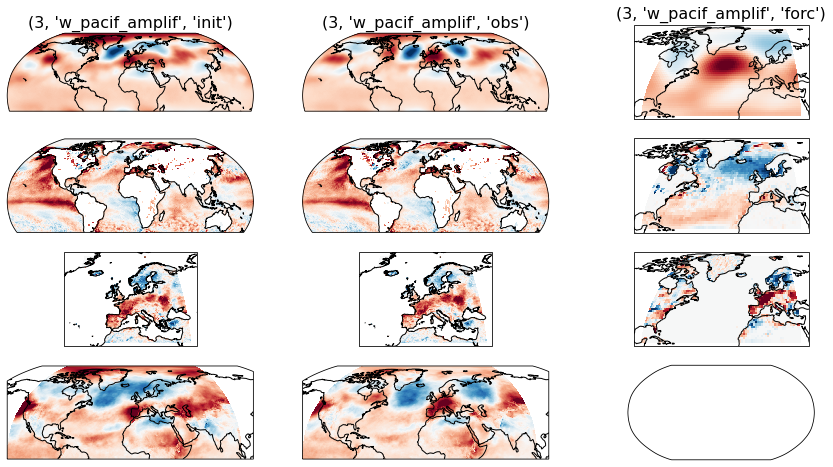

In [169]:
## Visualisation test, single slice, both init and 
npreds = 3
slicename = 'w_pacif_amplif'
fields = final.loc[:,(npreds,slicename,slice(None))]
plotcomposites(fields, coastlines=True, limit_domain=True)
plt.show()

SST is interesting. Although scale is different, probably the cold too zonally eastward extended? (Because the atmospheric pattern is wrong?). Soil moisture dipole seems persistent and corresponding to both initialization and and observation.

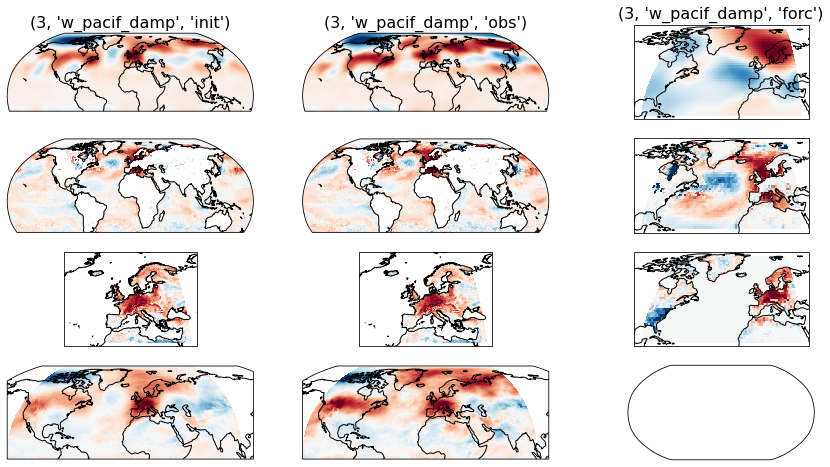

In [170]:
npreds = 3
slicename = 'w_pacif_damp'
fields = final.loc[:,(npreds,slicename,slice(None))]
plotcomposites(fields, coastlines=True)
plt.show()

Here the high pressure seems better placed. There is already atmospheric heat. Also sst good (there is already heat in the initialization and cold over the atlantic). Perhaps there is indeed less correction needed.

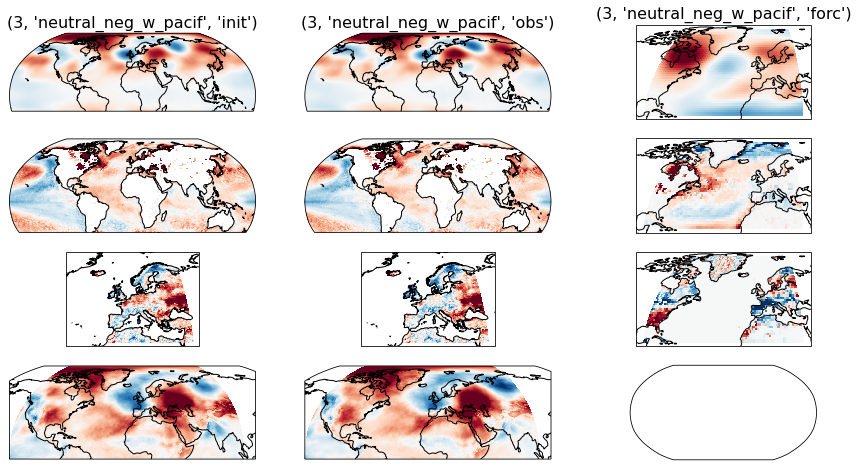

In [171]:
npreds = 3
slicename = 'neutral_neg_w_pacif'
fields = final.loc[:,(npreds,slicename,slice(None))]
plotcomposites(fields, coastlines=True)
plt.show()

Here swvl gets wetter during the two weeks of leadtime. Geopotential roughly right, pretty persistent from init to obs. Model has perhaps the low pressure not enough over great brittain (storm track pushed south). Model has this wettening too far south?

## Situation (local) as forecast by the model

In [19]:
# Over or under-estimation (of average temperature, not binarized yet)
#test = pd.read_hdf('/nobackup_1/users/straaten/match/paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean_e39fc4cbb84c4f9ab1fa4b346eb9aa42.h5')
#test['separation'] = test['leadtime'] -1
#test = test.set_index(['time','clustid','separation']).sort_index().loc[(slice(None),9,slice(None)),:]
#test.index = test.index.droplevel('clustid')

In [105]:
npreds = 3
focus_class = -1
order = get_data(npreds = npreds, std= False)[0].index
forcs = pd.read_hdf('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_forc.h5').reindex(order)
obs = pd.read_hdf('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_obs.h5').reindex(order)
slices = get_slices(npreds = npreds)
for name, sl in slices.items():
    print(name, 'forc:',forcs.iloc[sl,focus_class].mean(), 'obs:', obs.iloc[sl,focus_class].mean())

w_pacif_amplif forc: 0.53305614 obs: 0.95384616
w_pacif_damp forc: 0.72260445 obs: 0.8
neutral_neg_w_pacif forc: 0.52168036 obs: 0.1826087


## Zoom on West-pacific sst pattern in initialization

In [37]:
clust = xr.open_dataset('/nobackup_1/users/straaten/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)
clust = clust.sel(fold = 4, lag = -(15+21))
corrpattern = clust['correlation'].where(clust['clustid'] == 4, np.nan)

In [38]:
npreds = 3
patterns = final.loc['sst',(npreds,slice(None),'init')]

In [39]:
patterns.index

MultiIndex([(3,      'w_pacif_amplif', 'init'),
            (3,        'w_pacif_damp', 'init'),
            (3, 'neutral_neg_w_pacif', 'init')],
           names=['npreds', 'slice', 'moment'])

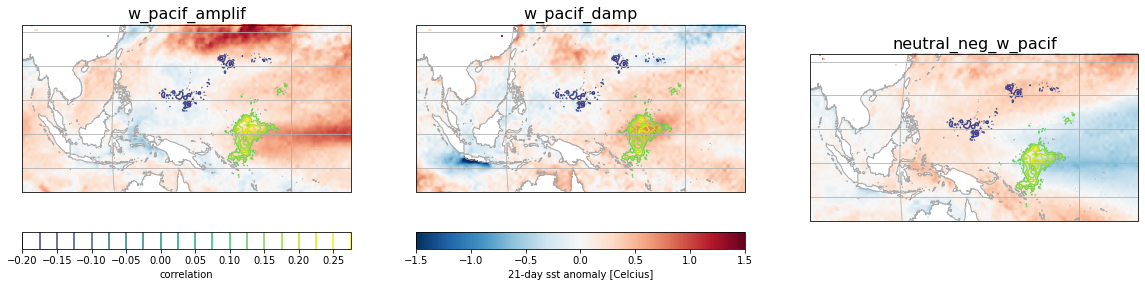

In [167]:
proj_crs = ccrs.Robinson(central_longitude=180)
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = len(patterns), squeeze = True, figsize = (20,5))
for i, key in enumerate(patterns.index):
    ax = axes[i]
    ax.set_extent((90,-160,-10,20))
    im = ax.pcolormesh(*data_for_pcolormesh(patterns.loc[key], shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = -1.5,vmax = 1.5)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')
    X, Y = np.meshgrid(corrpattern.longitude, corrpattern.latitude)
    line_c = ax.contour(X, Y, corrpattern.values, levels = 20, transform = array_crs, 
               zorder = 2, vmin = -0.25, vmax = 0.25)
    
    #ax.clabel(line_c,colors=['black'])
    ax.gridlines()
    ax.set_title(key[1], size = 16)
fig.colorbar(line_c, ax = axes[0], location = 'bottom', label = 'correlation')
fig.colorbar(im, ax = axes[1], location = 'bottom', label = '21-day sst anomaly [Celcius]')
plt.savefig(os.path.expanduser('~/Pictures/westpacif_init.png'), dpi = 130)

In [156]:
line_c

This looks as ifthe middle configuration would see the largest input signal. The negative situation is indeed clear. Looks like a La nina situation?